## Experiment description

Regression model comparison for the CFD shaft data. 

Model has 5 inputs and 5 outputs.


### Model

Run interactively on the web at: https://rcalix1.github.io/ProbabilityDensityFunctionsFromNeuralNets/experiments/july2022/CFDshaft/index.html


### Inputs

(1, 'i_pul_coal_inj_kg_thm')

(2, 'i_nat_gas_inj_kg_thm')

(3, 'i_nat_gas_t_k')

(4, 'i_o2_vol_perce')

(10, 'i_ore_weight_kg')

### Outputs

(17, 'o_shaft_co_utiliz')

(18, 'o_shaft_h2_utiliz')

(19, 'o_shaft_top_gas_temp_c')

(20, 'o_shaft_press_drop_pa')

(21, 'o_shaft_coke_rate_kg_thm')





In [122]:
################################################
##
## regression with DL for system control
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 50000
batch_size = 10
learning_rate =  0.01    ## 0.01   ## 1e-5 

## probably need adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

In [62]:
CFD_raw_data = pd.read_csv('CFD.6.2022.csv') 

In [63]:
headers_list = CFD_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['index', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_cohes_zone_root_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
28
(0, 'index')
(1, 'i_pul_coal_inj_kg_thm')
(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')
(5, 'i_bf_windrate_nm3_hr')
(6, 'i_hb_moist_g_nm3')
(7, 'i_hot_blast_press_pa')
(8, 'i_hot_blast_temp_k')
(9, 'i_coke_weight_kg')
(10, 'i_ore_weight_kg')
(11, 'o_tuyere_exit_velo_m_s')
(12, 'o_tuyere_t_k')
(13, 'o_raceway_flame_temp_k')
(14

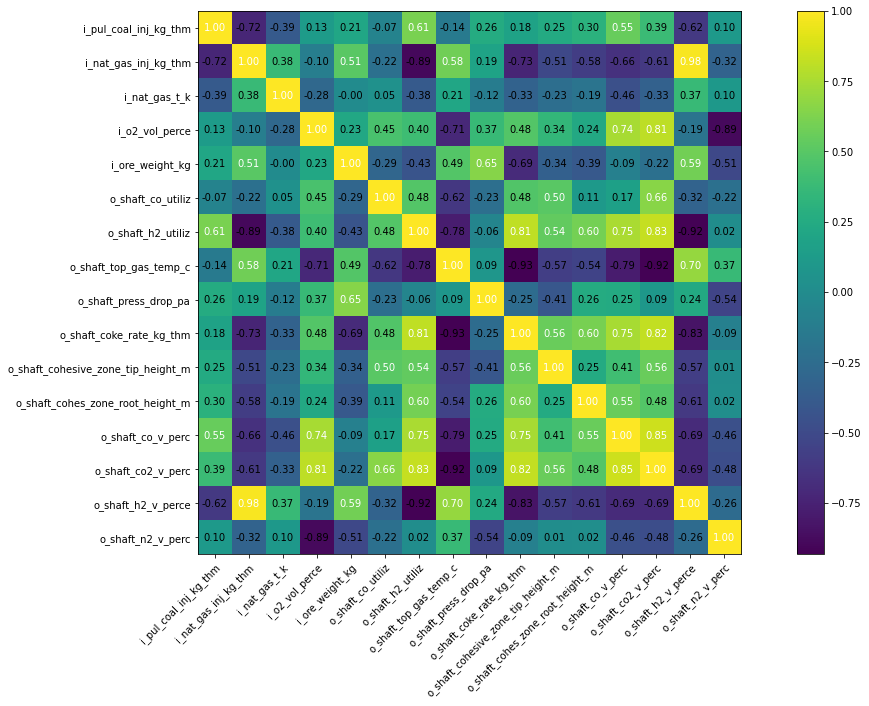

In [64]:
my_allInputs_shaft_names = ['i_pul_coal_inj_kg_thm','i_nat_gas_inj_kg_thm','i_nat_gas_t_k','i_o2_vol_perce',
                            'i_ore_weight_kg', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 
                            'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 
                            'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_cohes_zone_root_height_m', 
                            'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']



cm = np.corrcoef(CFD_raw_data[my_allInputs_shaft_names].values.T)
hm = heatmap(cm, row_names=my_allInputs_shaft_names, column_names=my_allInputs_shaft_names, figsize=(20, 10))
plt.show()

In [65]:
CFDdata_np = CFD_raw_data.to_numpy()
print(CFDdata_np)
print(CFDdata_np.shape)

[[ 1.          0.         37.9        ...  0.1941631   0.0438327
   0.5448123 ]
 [ 2.          0.         37.9        ...  0.2186134   0.04034286
   0.5149459 ]
 [ 3.          0.         37.9        ...  0.2353341   0.03772617
   0.4849808 ]
 ...
 [54.         70.          0.         ...  0.2279862   0.02182447
   0.5193577 ]
 [55.         70.          0.         ...  0.2387356   0.02094042
   0.4884186 ]
 [56.         70.          0.         ...  0.2464429   0.01986916
   0.4608655 ]]
(56, 28)


In [66]:
#######################################################


def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss:', loss_fn(   y_train_tr,         model(X_train_tr)                     ))
    print('Training R**2:', r2_score(  y_train_tr.numpy(), model(X_train_tr).detach().numpy()    ))
    
#######################################################

In [67]:
#######################################################

input_indeces  = [1, 2, 3, 4, 10]
output_indeces = [17, 18, 19, 20, 21]                            

#######################################################

X = CFDdata_np[:, input_indeces]

y = CFDdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56, 5)
(56, 5)
(44, 5)
(12, 5)
(44, 5)
(12, 5)


In [68]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

In [69]:


###################################################################
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon

X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations



In [70]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

In [71]:
#######################################################
## Linear Regression

class LinRegNet_SI(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(5, 5) 
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        return x

    
#############################################################


class MLP_Net_SI(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(5, 10)
        self.act1    = nn.ReLU() 
        self.linear2 = nn.Linear(10, 5)
        self.dropout = nn.Dropout(0.25)
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
        
        
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x
    

#############################################################


class DL_Net_SI(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(5, 10)
        self.act1    = nn.Tanh()                         ## ReLU() 
        self.linear2 = nn.Linear(10, 10)
        self.act2    = nn.Tanh()
        self.linear3 = nn.Linear(10, 5)
        self.dropout = nn.Dropout(0.25)
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
        
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        
        return x

      
#############################################################

In [72]:


model = LinRegNet_SI(x_means, x_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit(N_EPOCHS, model, loss_fn, opt)

print('Test loss:', loss_fn(       model(X_test_tr),                    y_test_tr            ))
print('Testing R**2:', r2_score(   model(X_test_tr).detach().numpy(),   y_test_tr.numpy()    ))



Training loss: tensor(2174933760., grad_fn=<MseLossBackward0>)
Training R**2: -16.0090702567846
Test loss: tensor(2040797952., grad_fn=<MseLossBackward0>)
Testing R**2: -289.6426610438706


In [73]:
model = MLP_Net_SI(x_means, x_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit(N_EPOCHS, model, loss_fn, opt)

print('Test loss:', loss_fn(       model(X_test_tr),                    y_test_tr            ))
print('Testing R**2:', r2_score(   model(X_test_tr).detach().numpy(),   y_test_tr.numpy()    ))

Training loss: tensor(119695864., grad_fn=<MseLossBackward0>)
Training R**2: -4.681656954205644
Test loss: tensor(78157440., grad_fn=<MseLossBackward0>)
Testing R**2: -0.89650686330416


In [74]:
model = DL_Net_SI(x_means, x_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit(N_EPOCHS, model, loss_fn, opt)

print('Test loss:', loss_fn(       model(X_test_tr),                    y_test_tr            ))
print('Testing R**2:', r2_score(   model(X_test_tr).detach().numpy(),   y_test_tr.numpy()    ))

Training loss: tensor(80043632., grad_fn=<MseLossBackward0>)
Training R**2: -0.56053129064688
Test loss: tensor(88080640., grad_fn=<MseLossBackward0>)
Testing R**2: -525.6145998738118


## Now scale outputs (y) as well

In [75]:
###################################################################
## for multiple regression outputs, normalize the y tensors too? 
## usually this is not done, but testing here

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations

####################################################################

In [76]:
#######################################################


def fit_y_scaled(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################

In [77]:


#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################



In [123]:
#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(5, 5) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################


class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(5, 10)
        self.act1    = nn.Tanh()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 5)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(5, 10)
        self.act1    = nn.Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Tanh() 
        self.linear3 = nn.Linear(6, 5)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################

In [125]:
model = LinRegNet_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.2249, grad_fn=<MseLossBackward0>)
Training R**2: 0.49241795954805834
Test loss - scaled: tensor(0.2641, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(13774836., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.3418348918295912
Testing R**2 - descaled: 0.34183495954461607


In [126]:
model = MLP_Net_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.1985, grad_fn=<MseLossBackward0>)
Training R**2: 0.7279039497137778
Test loss - scaled: tensor(0.2694, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(12842396., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.49508879601695277
Testing R**2 - descaled: 0.49508884587041263


In [127]:
model = DL_Net_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.3439, grad_fn=<MseLossBackward0>)
Training R**2: 0.5106172588959806
Test loss - scaled: tensor(0.4203, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(20264538., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.3278073912993402
Testing R**2 - descaled: 0.3278071501304892


## Re-Run best model and generate ONNX model

Re-running the MLP model which seems best. 

## Multi-Layer Perceptron (MLP)

In [128]:
model = MLP_Net_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.2149, grad_fn=<MseLossBackward0>)
Training R**2: 0.710460255309982
Test loss - scaled: tensor(0.2670, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(8959772., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.5276564556631804
Testing R**2 - descaled: 0.527656756848148


In [129]:


for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(X_test_tr[i])
    ## print(  preds_descaled.shape  )
    ## print(  preds_descaled  )
    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = y_test_tr[i].detach().numpy()
    ## print(np_pred.shape)
    ## print(np_real.shape)

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))



**************************************************
preds, real
(47.53275, 47.20085)
(43.183174, 42.99392)
(106.71529, 118.8785)
(107684.75, 108434.33)
(455.73926, 462.73654)
**************************************************
preds, real
(49.03227, 48.77197)
(44.96832, 43.93872)
(92.16277, 104.5031)
(114331.62, 101647.98)
(464.87985, 454.2938)
**************************************************
preds, real
(44.254692, 45.39389)
(38.23703, 38.58053)
(172.08932, 161.693)
(129474.664, 145817.1)
(332.38998, 338.47974)
**************************************************
preds, real
(47.199863, 47.41552)
(42.707836, 41.68419)
(123.6252, 120.5203)
(111260.41, 111601.02)
(424.1578, 417.48065)
**************************************************
preds, real
(48.20008, 47.23678)
(41.60736, 40.99704)
(127.24533, 133.2513)
(113087.65, 115654.4)
(398.25333, 398.264)
**************************************************
preds, real
(48.094814, 46.65558)
(47.78396, 43.13493)
(70.3902, 77.2359)
(123942.48, 11

In [130]:
'''

model.eval()

dummy_input = torch.randn(1, 5)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/CFDshaftSIO_mlp.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''